# EEG bench mark model

In [5]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from os.path import join

# from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMRegressor


Bad key "text.kerning_factor" on line 4 in
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Regression with LGBM (boosted trees) and Lasso

### Load data

In [7]:
path_to_data = join('data', 'processed_features_and_labels', '2')

In [4]:
X = np.load(join(path_to_data, 'data_features.npy'))
# X = np.concatenate((X[:, :53], X[:, 57:]), axis=1)
X.shape

(614, 93)

In [6]:
y = np.load(join(path_to_data, 'data_slope.npy'))

In [7]:
np.mean(y)

-0.11074918566775244

### Inspect if there are colinearities

In [268]:
corr = np.corrcoef(X, rowvar=0)

In [106]:
corr[np.isnan(corr)] = 0

In [269]:
w, v = np.linalg.eig(corr)

In [270]:
w

array([2.72858044e+01, 1.13342864e+01, 4.53048459e+00, 4.10070633e+00,
       3.92938269e+00, 3.79094042e+00, 3.20452311e+00, 2.55925525e+00,
       2.37892902e+00, 2.18303241e+00, 2.12138890e+00, 2.04855108e+00,
       1.41998906e+00, 1.24856500e+00, 1.20252950e+00, 1.07356650e+00,
       9.70559120e-01, 9.52440078e-01, 9.03457863e-01, 8.37640319e-01,
       7.68632738e-01, 7.30484123e-01, 6.97316336e-01, 6.50017547e-01,
       6.37953677e-01, 5.95454953e-01, 5.89098157e-01, 5.03639281e-01,
       4.84005660e-01, 4.76920380e-01, 4.49468237e-01, 4.34665341e-01,
       4.06963767e-01, 3.76712851e-01, 3.63299400e-01, 3.50538213e-01,
       3.29305976e-01, 3.12936970e-01, 2.95945370e-01, 2.80917494e-01,
       2.58988118e-01, 2.50022028e-01, 2.40392419e-01, 2.43737296e-01,
       2.28809943e-01, 2.17020901e-01, 2.02839590e-01, 2.00965634e-01,
       1.91546637e-01, 1.65483955e-01, 1.78634206e-01, 1.79618589e-01,
       1.59525180e-01, 1.50193995e-01, 1.54765500e-01, 1.41138637e-01,
      

### Seperate training and testing set

Dog scene for participant 2 is from 328233ms - 549067ms, extract that as test set

In [12]:
dog_start = 328233 // 1000
dog_end = 549067 // 1000

In [13]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]
y_train, y_test = np.expand_dims(y_train, axis=1), np.expand_dims(y_test, axis=1)

In [14]:
y_test.shape

(221, 1)

### LGBM

In [19]:
lgbm = TransformedTargetRegressor(
    regressor=LGBMRegressor(), # lightgbm boosted tree
    transformer=StandardScaler()) # using standard scaler

In [20]:
param_grid = {
    "regressor__num_leaves" : [11, 31, 51]
}

In [21]:
grid_search = GridSearchCV(lgbm, param_grid, return_train_score=True, verbose=2, n_jobs=-1)

In [22]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.6s finished


GridSearchCV(estimator=TransformedTargetRegressor(regressor=LGBMRegressor(),
                                                  transformer=StandardScaler()),
             n_jobs=-1, param_grid={'regressor__num_leaves': [11, 31, 51]},
             return_train_score=True, verbose=2)

In [23]:
grid_search.best_score_

-0.36442737989815377

### Lasso

In [24]:
lasso = TransformedTargetRegressor(
    regressor=LassoCV(), # ridge linear regression
    transformer=StandardScaler()) # using standard scaler
cvscore = cross_val_score(lasso, X_train, y_train)

In [25]:
cvscore

array([-0.00371092, -0.00138264, -0.00391554, -0.04382505, -0.04527138])

## Slope classification with multiple models

array([0.62703583])

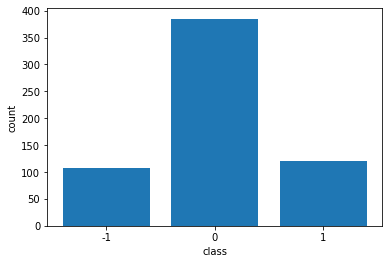

In [45]:
y = np.load(join(path_to_data, 'data_slope.npy'))
s = StandardScaler()
y = s.fit_transform(np.expand_dims(y, axis=1))

y[abs(y) < 0.25] = 0
y[y >= 0.25] = 1
y[y <= -0.25] = -1

plt.xlabel("class")
plt.ylabel("count")
plt.bar(["-1", "0", "1"], [np.sum(y == -1), np.sum(y == 0), np.sum(y == 1)])
sum(abs(y) < 0.25) / y.shape[0]

### Visualize feature and label space with tSNE

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(X)
# transformed = pca.transform(X)

In [28]:
np.squeeze(y).shape

(614,)

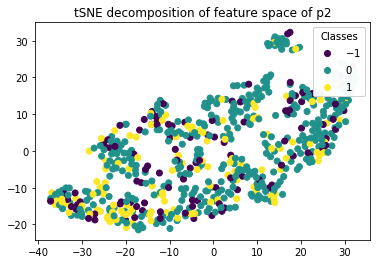

In [29]:
%matplotlib inline
# pca.explained_variance_ratio_
fig, ax = plt.subplots()

s = ax.scatter(transformed[:,0], transformed[:,1], c=np.squeeze(y))
plt.title("tSNE decomposition of feature space of p2")
ax.add_artist(ax.legend(*s.legend_elements(),
                    loc="upper right", title="Classes"))
# pca.components_.shape

In [46]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]

### Feature selection with RFECV (Recursive Feature elimination with cross validation)

In [50]:

rfe_validation = RFECV(RandomForestClassifier(), step=0.5, verbose=2)
rfe_validation.fit(X_train, np.ravel(y_train))

Fitting estimator with 93 features.
Fitting estimator with 47 features.
Fitting estimator with 93 features.
Fitting estimator with 47 features.
Fitting estimator with 93 features.
Fitting estimator with 47 features.
Fitting estimator with 93 features.
Fitting estimator with 47 features.
Fitting estimator with 93 features.
Fitting estimator with 47 features.


RFECV(estimator=RandomForestClassifier(), step=0.5, verbose=2)

In [57]:
np.where(rfe_validation.ranking_ == 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]),)

In [58]:
rfe_validation.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### Classification with random forest on selected features (currently all features)

In [59]:
forest = RandomForestClassifier()
param_grid = {
    "criterion" : ["gini", "entropy"],
    "max_depth": [10, 100, 1000],
    "min_samples_leaf": [1, 10, 100]
}
grid_search = GridSearchCV(forest, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train[:,rfe_validation.support_], y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.0s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 100, 1000],
                         'min_samples_leaf': [1, 10, 100]},
             return_train_score=True, verbose=2)

In [60]:
grid_search.best_score_

0.6691983122362869

In [61]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}

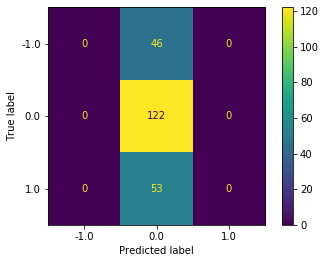

In [62]:
plot_confusion_matrix(grid_search.best_estimator_, X_test[:,rfe_validation.support_], y_test)

### Classification with logistic regression on selected features (currently all features)

In [63]:
from sklearn.linear_model import LogisticRegression
lr = Pipeline([
    ('standardization', StandardScaler()),
    ('lr', LogisticRegression())
])
cv_score = cross_validate(lr, X_train[:,rfe_validation.support_], y_train, return_train_score=True, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [64]:
pd.DataFrame(cv_score)

,fit_time,score_time,test_score,train_score
0,0.202812,0.000716,0.658228,0.799363
1,0.225084,0.000750,0.417722,0.859873
2,0.172132,0.001052,0.303797,0.837580
3,0.198670,0.000932,0.487179,0.812698
4,0.098686,0.001095,0.628205,0.787302


In [65]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

array([[  9,  41,  12],
       [ 53, 172,  38],
       [ 10,  43,  15]])

/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


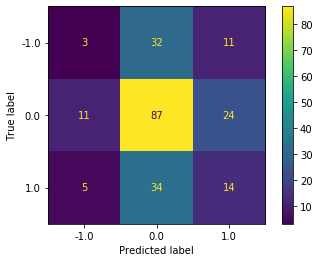

In [67]:
lr.fit(X_train, y_train)
plot_confusion_matrix(lr, X_test[:,rfe_validation.support_], y_test)

In [80]:
y_pred = lr.predict(X_test[:,rfe_validation.support_])
np.sum(y_pred == np.squeeze(y_test)) / len(y_pred)

0.47058823529411764

### Classification with KNN on selected features (currently all features)

In [81]:
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors" : np.arange(3)
}
grid_search = RandomizedSearchCV(knn, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train[:,rfe_validation.support_], y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.2s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': array([0, 1, 2])},
                   return_train_score=True, verbose=2)

In [82]:
pd.DataFrame(grid_search.cv_results_)[["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,NaN,NaN
1,1.000000,0.508926
2,0.757001,0.496138


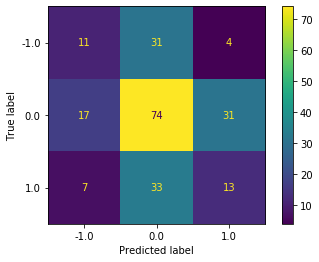

In [83]:
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)

### Inspecting distances between training examples

In [84]:
from sklearn.metrics.pairwise import euclidean_distances

class_1 = X_train[np.squeeze(y_train == 1)]
class_0 = X_train[np.squeeze(y_train == 0)]
class_neg_1 = X_train[np.squeeze(y_train == -1)]

d_1_0 = euclidean_distances(class_neg_1, class_1)

(array([1002., 1553.,  843.,  345.,  216.,  107.,   63.,   37.,   38.,
          12.]),
 array([  26698.56264732,  138653.3458446 ,  250608.12904187,
         362562.91223915,  474517.69543643,  586472.47863371,
         698427.26183098,  810382.04502826,  922336.82822554,
        1034291.61142281, 1146246.39462009]),
 <a list of 10 Patch objects>)

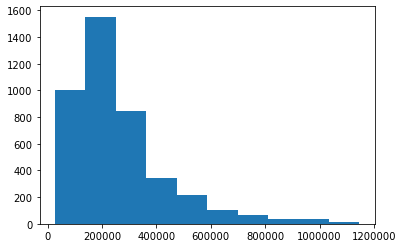

In [85]:
plt.hist(d_1_0.flatten())

In [86]:
d_1_0.max(), d_1_0.min()

(1146246.3946200914, 26698.562647318682)

In [87]:
sum(d_1_0.flatten() == 0.0), class_1.shape[0]

(0, 68)

### Classification with support vector machine

In [88]:
svc = SVC()
param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 10e5]
}
grid_search = GridSearchCV(svc, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   24.8s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000000.0]},
             return_train_score=True, verbose=2)

In [89]:
pd.DataFrame(grid_search.cv_results_)[["mean_train_score", "mean_test_score", "param_C"]]

,mean_train_score,mean_test_score,param_C
0,0.669210,0.669198,0.001
1,0.669210,0.669198,0.01
2,0.669210,0.669198,0.1
3,0.669210,0.669198,1
4,0.669210,0.669198,10
5,0.674933,0.658974,100
6,0.949115,0.486043,1e+06


In [90]:
grid_search.best_score_

0.6691983122362869

In [91]:
grid_search.best_params_

{'C': 0.001}

In [92]:
confusion_matrix(y_train, cross_val_predict(grid_search.best_estimator_, X_train, y_train))

/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

array([[  0,  62,   0],
       [  0, 263,   0],
       [  0,  68,   0]])

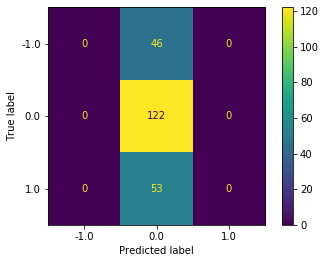

In [93]:
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)

### Classification with simple neural network

In [210]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier((100,100,20,5), max_iter=300).fit(X_train, np.ravel(y_train))
# confusion_matrix(y_train, cross_val_predict(clf, X_train, y_train))
pd.DataFrame(cross_val_score(clf, X_train, np.ravel(y_train)))


/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,0
0,0.666667
1,0.666667
2,0.658120
3,0.658120
4,0.658120


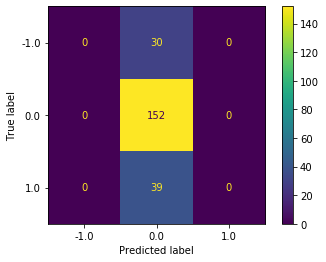

In [211]:
plot_confusion_matrix(clf, X_test, y_test)

### Regression on emotion state

(array([  0.,  11.,  31.,  35., 132., 127.,  89.,  97.,  44.,  18.,  24.,
          5.]),
 array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
         2.5,  3. ]),
 <a list of 12 Patch objects>)

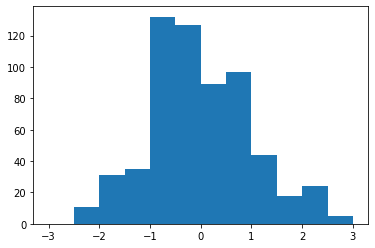

In [8]:
y = np.load(join(path_to_data, 'data_state.npy'))
s = StandardScaler()
y = s.fit_transform(np.expand_dims(y, axis=1))
plt.hist(y, bins=np.arange(-3, 3.5, 0.5))

In [96]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]
# y_train, y_test = np.expand_dims(y_train, axis=1), np.expand_dims(y_test, axis=1)

In [97]:
param_grid = {
    "regressor__num_leaves" : [11, 31, 51]
}
grid_search = GridSearchCV(lgbm, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search

GridSearchCV(estimator=TransformedTargetRegressor(regressor=LGBMRegressor(),
                                                  transformer=StandardScaler()),
             n_jobs=-1, param_grid={'regressor__num_leaves': [11, 31, 51]},
             return_train_score=True, verbose=2)

In [98]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


GridSearchCV(estimator=TransformedTargetRegressor(regressor=LGBMRegressor(),
                                                  transformer=StandardScaler()),
             n_jobs=-1, param_grid={'regressor__num_leaves': [11, 31, 51]},
             return_train_score=True, verbose=2)

In [147]:
grid_search.best_score_

-0.4181378129032568

### Classification on emotion state

In [4]:
y = np.load(join(path_to_data, 'data_state.npy'))
s = MinMaxScaler((-10, 10))
y = s.fit_transform(np.expand_dims(y, axis=1))
y.shape

(614, 1)

(array([ 20.,  23.,  96., 187.,  85.,  88.,  64.,  21.,  22.,   8.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

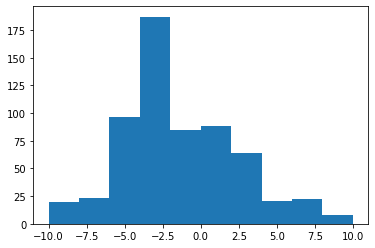

In [5]:
plt.hist(y)

<BarContainer object of 3 artists>

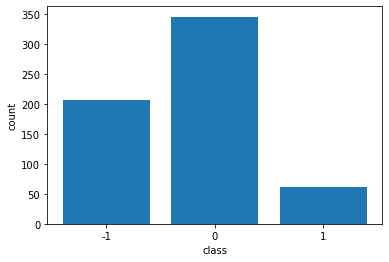

In [9]:
y = np.load(join(path_to_data, 'data_state.npy'))
s = MinMaxScaler((-10, 10))
y = s.fit_transform(np.expand_dims(y, axis=1))

y[abs(y) < (10.0/3)] = 0
y[y >= (10.0/3)] = 1
y[y <= -(10.0/3)] = -1

plt.xlabel("class")
plt.ylabel("count")
plt.bar(["-1", "0", "1"], [np.sum(y == -1), np.sum(y == 0), np.sum(y == 1)])

In [156]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]

In [158]:
svc = SVC()
param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(svc, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.4s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, verbose=2)

In [161]:
grid_search.best_score_

0.5340137035701407

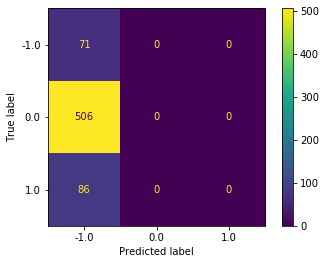

In [166]:
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)